In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load stock data from CSV (without 'Symbol' filtering)
def get_stock_data_from_csv(filename):
    try:
        # Read CSV and parse dates
        data = pd.read_csv(filename, parse_dates=['Date'])
        
        # Ensure correct column names exist
        expected_columns = {'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'}
        if not expected_columns.issubset(set(data.columns)):
            raise ValueError(f"Dataset is missing expected columns. Found: {list(data.columns)}")
        
        # Set date as index and sort
        data.set_index('Date', inplace=True)
        data.sort_index(inplace=True)
        
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [3]:
# Calculate 50-day and 200-day Simple Moving Averages (SMA)
def calculate_sma(data, short_window=50, long_window=200):
    data['SMA_50'] = data['Adj Close'].rolling(window=short_window).mean()
    data['SMA_200'] = data['Adj Close'].rolling(window=long_window).mean()
    
    # Drop NaN values caused by rolling calculations
    data.dropna(inplace=True)
    return data

In [4]:
# Generate buy/sell signals based on SMA crossover
def generate_signals(data):
    data['Signal'] = 0  
    data.loc[data['SMA_50'] > data['SMA_200'], 'Signal'] = 1  # Buy
    data.loc[data['SMA_50'] < data['SMA_200'], 'Signal'] = -1  # Sell
    return data

In [5]:
# Backtest strategy with initial capital
def backtest_strategy(data, initial_capital=10000):
    capital = initial_capital
    position = 0  

    for i in range(1, len(data)):
        if data['Signal'].iloc[i] == 1:  # Buy signal
            position = capital / data['Adj Close'].iloc[i]
            capital = 0  
        elif data['Signal'].iloc[i] == -1 and position > 0:  # Sell signal
            capital = position * data['Adj Close'].iloc[i]
            position = 0  

    # If still holding a position, calculate final value
    return capital if position == 0 else position * data['Adj Close'].iloc[-1]

In [6]:
# Evaluate performance metrics
def evaluate_performance(data):
    total_trades = (data['Signal'].diff() != 0).sum()
    volatility = data['Adj Close'].pct_change().std()
    return total_trades, volatility

In [7]:
# Plot stock price with SMA crossover
def plot_results(data, filename):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Adj Close'], label='Adjusted Closing Price', color='blue')
    plt.plot(data.index, data['SMA_50'], label='50-day SMA', color='orange')
    plt.plot(data.index, data['SMA_200'], label='200-day SMA', color='red')
    plt.scatter(data.index[data['Signal'] == 1], data['Adj Close'][data['Signal'] == 1], label='Buy', marker='^', color='green', alpha=1)
    plt.scatter(data.index[data['Signal'] == -1], data['Adj Close'][data['Signal'] == -1], label='Sell', marker='v', color='red', alpha=1)
    plt.legend()
    plt.title(f"Stock Analysis for {filename}")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.grid()
    plt.show()

Initial Capital: $10000
Final Capital: $0.00
Total Trades Executed: 52
Strategy Volatility: 0.0286


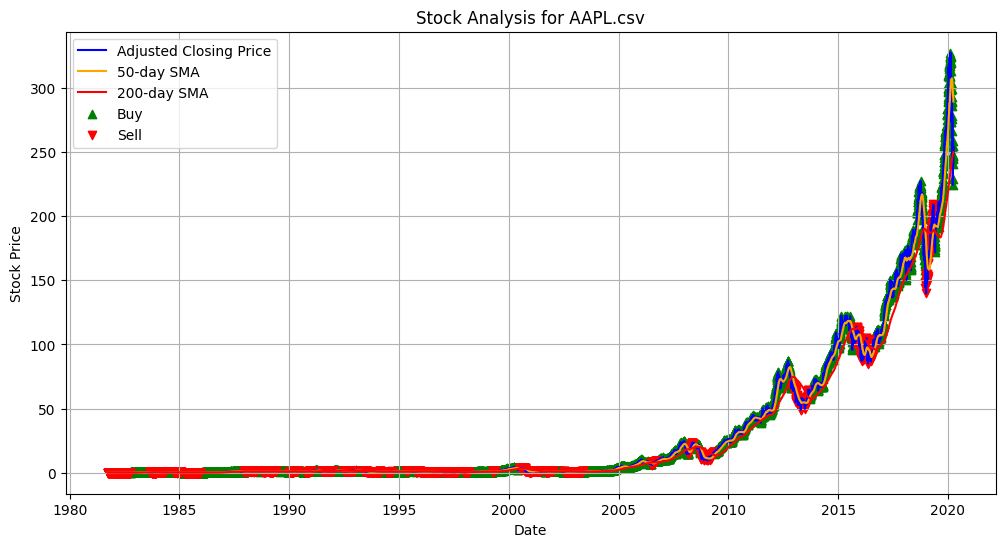

In [8]:
# Main function
def main():
    filename = "/kaggle/input/stock-market-dataset/stocks/AAPL.csv"  # Change this to match your dataset path in Kaggle

    data = get_stock_data_from_csv(filename)
    if data is None:
        print("Exiting program due to data loading issues.")
        return  

    data = calculate_sma(data)
    data = generate_signals(data)

    initial_capital = 10000
    final_capital = backtest_strategy(data, initial_capital)
    total_trades, volatility = evaluate_performance(data)

    print(f'Initial Capital: ${initial_capital}')
    print(f'Final Capital: ${final_capital:.2f}')
    print(f'Total Trades Executed: {total_trades}')
    print(f'Strategy Volatility: {volatility:.4f}')

    plot_results(data, filename.split('/')[-1])  # Use filename as label

# Run the program
if __name__ == "__main__":
    main()
